In [ ]:
"""
==============================================================
Dataset Preparation & Machine Learning for Densification of La2Ti2O7
==============================================================

This script constructs the final dataset by combining experimental features,
replicated density measurements, synthetic augmentation, and engineered features.
It further implements machine learning models for densification prediction.

Author : Bagas Haqi Arrosyid
"""

# ==============================================================
# STEP 0: Import Required Libraries
# ==============================================================

import pandas as pd
import numpy as np
import random
import sys
import subprocess

# Try to import CatBoost, install if not available
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    print("CatBoost not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "catboost"])
    from catboost import CatBoostRegressor

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# ==============================================================
# STEP 1: Set Random State
# ==============================================================

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ==============================================================
# STEP 2: Dataset Construction
# ==============================================================

# Experimental features
feature_data = {
    "Sample": ["SPS-LTO1000", "SPS-LTO1100", "SPS-LTO1200", "PS-LTO1100", "PS-LTO1200"],
    "Method": ["Spark Plasma", "Spark Plasma", "Spark Plasma", "Pressureless", "Pressureless"],
    "Sintering Time (min)": [15, 15, 15, 120, 120],
    "Temperature (°C)": [1000, 1100, 1200, 1100, 1200],
    "2θ": [29.781, 29.7507, 29.7501, 29.9154, 29.9323],
    "FWHM": [0.3829, 0.3064, 0.2882, 0.0889, 0.0814],
    "a (Å)": [7.8158, 7.8188, 7.8169, 7.7690, 7.7685],
    "b (Å)": [5.5478, 5.5459, 5.5454, 5.5145, 5.5152],
    "c (Å)": [12.997, 12.999, 13.001, 12.9396, 12.9390],
    "Cell Volume (Å³)": [561.28, 562.02, 563.13, 554.36, 554.36],
    "Crystallite Size (nm)": [21.9, 27.6, 29.4, 92.60, 100.96],
    "Strain ε": [0.00629, 0.00504, 0.00474, 0.00146, 0.00133],
    "Porosity (%)": [11.18, 7.78, 5.65, 20.39, 12.41],
    "Pore Count": [73.88, 64.6, 17.55, 206.55, 341.88],
    "Pore Size (px²)": [1597.09, 5788.84, 12065.19, 3769.78, 1764.79],
    "Pore STD": [11055.08, 32001.53, 48446.98, 52514.05, 15942.81],
    "Aspect Ratio": [2.09, 2.09, 2.14, 2.06, 2.03],
    "Eccentricity γ": [0.81, 0.81, 0.80, 0.80, 0.81],
}
df_features = pd.DataFrame(feature_data)

# Replicated density values
replicate_data = [
    ("Spark Plasma", 1000, 4.92424), ("Spark Plasma", 1000, 4.98235),
    ("Spark Plasma", 1000, 5.00687), ("Spark Plasma", 1000, 4.97919),
    ("Spark Plasma", 1000, 5.20735), ("Spark Plasma", 1100, 5.23372),
    ("Spark Plasma", 1100, 5.30640), ("Spark Plasma", 1100, 5.30426),
    ("Spark Plasma", 1100, 5.29490), ("Spark Plasma", 1100, 5.16072),
    ("Spark Plasma", 1200, 5.50201), ("Spark Plasma", 1200, 5.38067),
    ("Spark Plasma", 1200, 5.37429), ("Spark Plasma", 1200, 5.32747),
    ("Spark Plasma", 1200, 5.26556),
    ("Pressureless", 1100, 4.97798), ("Pressureless", 1100, 4.66460),
    ("Pressureless", 1100, 4.49239), ("Pressureless", 1100, 4.27164),
    ("Pressureless", 1100, 4.37727), ("Pressureless", 1200, 5.06392),
    ("Pressureless", 1200, 5.19976), ("Pressureless", 1200, 4.90032),
    ("Pressureless", 1200, 4.98405), ("Pressureless", 1200, 5.02807),
]
df_replicates = pd.DataFrame(replicate_data, columns=["Method", "Temperature (°C)", "Density"])

# Merge base features with density replicates
df_merged = pd.merge(df_replicates, df_features, on=["Method", "Temperature (°C)"], how="left")

# ==============================================================
# STEP 3: Data Augmentation & Feature Engineering
# ==============================================================

def augment_data(df, n_variants=3, noise_level=0.02):
    """
    Create synthetic data by adding Gaussian noise to numeric features.
    """
    augmented_rows = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns.drop("Density")

    for _, row in df.iterrows():
        for _ in range(n_variants):
            new_row = row.copy()
            for col in numeric_cols:
                new_row[col] += np.random.normal(0, noise_level * row[col])
            augmented_rows.append(new_row)

    return pd.DataFrame(augmented_rows)


def add_derived_features(df):
    """
    Add derived/engineered features to improve model performance.
    """
    df = df.copy()
    df["a/b"] = df["a (Å)"] / df["b (Å)"]
    df["a/c"] = df["a (Å)"] / df["c (Å)"]
    df["Strain×FWHM"] = df["Strain ε"] * df["FWHM"]
    df["FWHM²"] = df["FWHM"] ** 2
    df["Strain²"] = df["Strain ε"] ** 2
    df["Volume/Crystallite"] = df["Cell Volume (Å³)"] / df["Crystallite Size (nm)"]
    df["log(Crystallite)"] = np.log10(df["Crystallite Size (nm)"])
    df["PoreSize/Count"] = df["Pore Size (px²)"] / df["Pore Count"]
    df["STD/Size"] = df["Pore STD"] / df["Pore Size (px²)"]
    df["Aspect×Eccen"] = df["Aspect Ratio"] * df["Eccentricity γ"]
    df["log(Pore Size)"] = np.log10(df["Pore Size (px²)"])
    df["Pore Size²"] = df["Pore Size (px²)"] ** 2
    df["Porosity×STD"] = df["Porosity (%)"] * df["Pore STD"]
    return df


# Apply augmentation & feature engineering
df_augmented = augment_data(df_merged)
df_merged = add_derived_features(df_merged)
df_augmented = add_derived_features(df_augmented)

# Final dataset
df_all = pd.concat([df_merged, df_augmented], ignore_index=True).fillna(0)

# ==============================================================
# STEP 4: Machine Learning Pipeline
# ==============================================================

# Define features and target
y = df_all["Density"]
X = df_all.drop(columns=["Density", "Sample"])
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models and parameter grids
models_grids = {
    "Bagging Regressor": {
        "model": BaggingRegressor(random_state=SEED),
        "params": {
            "n_estimators": [10, 50, 100],
            "max_samples": [0.7, 1.0],
            "max_features": [0.7, 1.0],
        },
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=SEED, objective="reg:squarederror"),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.05, 0.1],
        },
    },
    "CatBoost": {
        "model": CatBoostRegressor(random_state=SEED, silent=True),
        "params": {
            "iterations": [100, 200],
            "depth": [3, 5, 7],
            "learning_rate": [0.01, 0.05, 0.1],
        },
    },
    "PLS Regression": {
        "model": PLSRegression(),
        "params": {"n_components": [2, 3, 4]},
    },
    "SVR": {
        "model": SVR(),
        "params": {"C": [1, 5, 10], "gamma": ["scale"], "epsilon": [0.05, 0.1]},
    },
}

# Cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Train & evaluate models
results, summary = {}, []
for name, mg in models_grids.items():
    print(f"\n--- Training & Tuning {name} ---")
    grid = GridSearchCV(mg["model"], mg["params"], cv=cv_strategy, scoring="r2", n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    results[name] = best_model

    # Evaluation
    y_pred = best_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    nrmse = (rmse / np.mean(y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    cv_r2 = cross_val_score(best_model, X_train_scaled, y_train, cv=cv_strategy, scoring="r2")

    summary.append({
        "Model": name,
        "Best_Params": grid.best_params_,
        "R2": r2,
        "CV_R2_mean": np.mean(cv_r2),
        "CV_R2_std": np.std(cv_r2),
        "RMSE": rmse,
        "nRMSE (%)": nrmse,
        "MAE": mae,
        "MAPE (%)": mape,
    })

# Collect results
df_results = pd.DataFrame(summary).sort_values(by="R2", ascending=False).reset_index(drop=True)
print("\n=== MODEL COMPARISON (sorted by R2) ===")
print(df_results)

# ==============================================================
# STEP 5: Save Predictions from Best Model
# ==============================================================

best_model_name = df_results.iloc[0]["Model"]
final_model = results[best_model_name]
final_model.fit(X_train_scaled, y_train)

df_all["Density_Pred"] = final_model.predict(scaler.transform(X))
df_all.to_csv("dataset_density_with_predictions.csv", index=False)

print("\nPredictions saved to 'dataset_density_with_predictions.csv'")


CatBoost not found. Installing...

--- Training & Tuning Bagging Regressor ---

--- Training & Tuning XGBoost ---

--- Training & Tuning CatBoost ---

--- Training & Tuning PLS Regression ---

--- Training & Tuning SVR ---

=== MODEL COMPARISON (sorted by R2) ===
               Model                                        Best_Params  \
0     PLS Regression                                {'n_components': 3}   
1  Bagging Regressor  {'max_features': 0.7, 'max_samples': 0.7, 'n_e...   
2           CatBoost  {'depth': 3, 'iterations': 100, 'learning_rate...   
3                SVR        {'C': 1, 'epsilon': 0.05, 'gamma': 'scale'}   
4            XGBoost  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...   

         R2  CV_R2_mean  CV_R2_std      RMSE  nRMSE (%)       MAE  MAPE (%)  
0  0.794341    0.740679   0.081756  0.167590   3.398253  0.132147  2.759633  
1  0.794283    0.768559   0.100477  0.167613   3.398732  0.133820  2.807516  
2  0.754708    0.771464   0.083401  0.183027   3.71

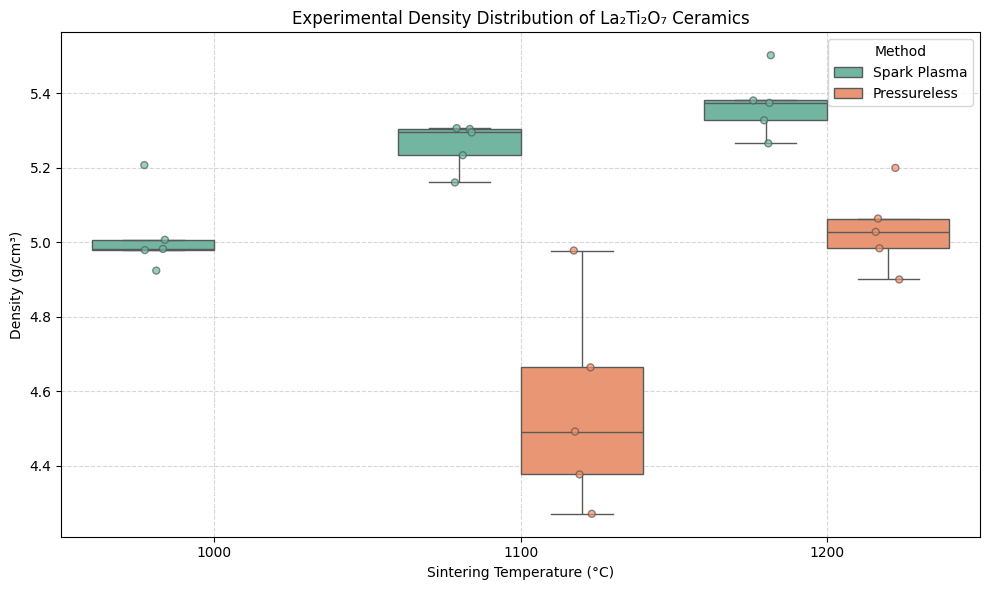

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# Step 2: Define replicated density measurements
# ==========================================================
replicate_data = [
    ("Spark Plasma", 1000, 4.92424), ("Spark Plasma", 1000, 4.98235),
    ("Spark Plasma", 1000, 5.00687), ("Spark Plasma", 1000, 4.97919),
    ("Spark Plasma", 1000, 5.20735), ("Spark Plasma", 1100, 5.23372),
    ("Spark Plasma", 1100, 5.30640), ("Spark Plasma", 1100, 5.30426),
    ("Spark Plasma", 1100, 5.29490), ("Spark Plasma", 1100, 5.16072),
    ("Spark Plasma", 1200, 5.50201), ("Spark Plasma", 1200, 5.38067),
    ("Spark Plasma", 1200, 5.37429), ("Spark Plasma", 1200, 5.32747),
    ("Spark Plasma", 1200, 5.26556),
    ("Pressureless", 1100, 4.97798), ("Pressureless", 1100, 4.66460),
    ("Pressureless", 1100, 4.49239), ("Pressureless", 1100, 4.27164),
    ("Pressureless", 1100, 4.37727), ("Pressureless", 1200, 5.06392),
    ("Pressureless", 1200, 5.19976), ("Pressureless", 1200, 4.90032),
    ("Pressureless", 1200, 4.98405), ("Pressureless", 1200, 5.02807),
]
df_replicates = pd.DataFrame(replicate_data, columns=["Method", "Temperature (°C)", "Density"])

# ==========================================================
# Plot density distribution
# ==========================================================
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_replicates, x="Temperature (°C)", y="Density", hue="Method",
            palette="Set2", fliersize=0)  # hide outliers (karena nanti kita pakai scatter)
sns.stripplot(data=df_replicates, x="Temperature (°C)", y="Density", hue="Method",
              dodge=True, jitter=True, marker="o", alpha=0.7, linewidth=1,
              palette="Set2")

# Improve legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Method")

plt.title("Experimental Density Distribution of La₂Ti₂O₇ Ceramics")
plt.ylabel("Density (g/cm³)")
plt.xlabel("Sintering Temperature (°C)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
"""
Dataset Preparation for Densification Analysis of La2Ti2O7
----------------------------------------------------------
This script builds the final dataset by combining experimental features,
replicated density measurements, synthetic augmentation, and derived features.

Author: Bagas Haqi Arrosyid
"""

import pandas as pd
import numpy as np


# ==========================================================
# Step 1: Define base feature dataset
# ==========================================================
feature_data = {
    "Sample": ["SPS-LTO1000", "SPS-LTO1100", "SPS-LTO1200", "PS-LTO1100", "PS-LTO1200"],
    "Method": ["Spark Plasma", "Spark Plasma", "Spark Plasma", "Pressureless", "Pressureless"],
    "Sintering Time (min)": [15, 15, 15, 120, 120],
    "Temperature (°C)": [1000, 1100, 1200, 1100, 1200],
    "2θ": [29.781, 29.7507, 29.7501, 29.9154, 29.9323],
    "FWHM": [0.3829, 0.3064, 0.2882, 0.0889, 0.0814],
    "a (Å)": [7.8158, 7.8188, 7.8169, 7.7690, 7.7685],
    "b (Å)": [5.5478, 5.5459, 5.5454, 5.5145, 5.5152],
    "c (Å)": [12.997, 12.999, 13.001, 12.9396, 12.9390],
    "Cell Volume (Å³)": [561.28, 562.02, 563.13, 554.36, 554.36],
    "Crystallite Size (nm)": [21.9, 27.6, 29.4, 92.60, 100.96],
    "Strain ε": [0.00629, 0.00504, 0.00474, 0.00146, 0.00133],
    "Porosity (%)": [11.18, 7.78, 5.65, 20.39, 12.41],
    "Pore Count": [73.88, 64.6, 17.55, 206.55, 341.88],
    "Pore Size (px²)": [1597.09, 5788.84, 12065.19, 3769.78, 1764.79],
    "Pore STD": [11055.08, 32001.53, 48446.98, 52514.05, 15942.81],
    "Aspect Ratio": [2.09, 2.09, 2.14, 2.06, 2.03],
    "Eccentricity γ": [0.81, 0.81, 0.80, 0.80, 0.81],
}
df_features = pd.DataFrame(feature_data)


# ==========================================================
# Step 2: Define replicated density measurements
# ==========================================================
replicate_data = [
    ("Spark Plasma", 1000, 4.92424), ("Spark Plasma", 1000, 4.98235),
    ("Spark Plasma", 1000, 5.00687), ("Spark Plasma", 1000, 4.97919),
    ("Spark Plasma", 1000, 5.20735), ("Spark Plasma", 1100, 5.23372),
    ("Spark Plasma", 1100, 5.30640), ("Spark Plasma", 1100, 5.30426),
    ("Spark Plasma", 1100, 5.29490), ("Spark Plasma", 1100, 5.16072),
    ("Spark Plasma", 1200, 5.50201), ("Spark Plasma", 1200, 5.38067),
    ("Spark Plasma", 1200, 5.37429), ("Spark Plasma", 1200, 5.32747),
    ("Spark Plasma", 1200, 5.26556),
    ("Pressureless", 1100, 4.97798), ("Pressureless", 1100, 4.66460),
    ("Pressureless", 1100, 4.49239), ("Pressureless", 1100, 4.27164),
    ("Pressureless", 1100, 4.37727), ("Pressureless", 1200, 5.06392),
    ("Pressureless", 1200, 5.19976), ("Pressureless", 1200, 4.90032),
    ("Pressureless", 1200, 4.98405), ("Pressureless", 1200, 5.02807),
]
df_replicates = pd.DataFrame(replicate_data, columns=["Method", "Temperature (°C)", "Density"])


# ==========================================================
# Step 3: Merge features and density data
# ==========================================================
df_merged = pd.merge(df_replicates, df_features, on=["Method", "Temperature (°C)"], how="left")


# ==========================================================
# Step 4: Synthetic augmentation
# ==========================================================
def augment_data(df, n_variants=3, noise_level=0.02):
    """
    Generate synthetic dataset by adding Gaussian noise
    to numeric features (excluding target 'Density').
    """
    augmented_rows = []
    num_cols = df.select_dtypes(include=[np.number]).columns.drop("Density")

    for _, row in df.iterrows():
        for _ in range(n_variants):
            new_row = row.copy()
            for col in num_cols:
                noise = np.random.normal(0, noise_level * row[col])
                new_row[col] = row[col] + noise
            augmented_rows.append(new_row)

    return pd.DataFrame(augmented_rows)


df_augmented = augment_data(df_merged)


# ==========================================================
# Step 5: Feature engineering
# ==========================================================
def add_derived_features(df):
    """
    Add physically meaningful derived features.
    """
    df = df.copy()
    df["a/b"] = df["a (Å)"] / df["b (Å)"]
    df["a/c"] = df["a (Å)"] / df["c (Å)"]
    df["Strain×FWHM"] = df["Strain ε"] * df["FWHM"]
    df["FWHM²"] = df["FWHM"] ** 2
    df["Strain²"] = df["Strain ε"] ** 2
    df["Volume/Crystallite"] = df["Cell Volume (Å³)"] / df["Crystallite Size (nm)"]
    df["log(Crystallite)"] = np.log10(df["Crystallite Size (nm)"])
    df["PoreSize/Count"] = df["Pore Size (px²)"] / df["Pore Count"]
    df["STD/Size"] = df["Pore STD"] / df["Pore Size (px²)"]
    df["Aspect×Eccen"] = df["Aspect Ratio"] * df["Eccentricity γ"]
    df["log(Pore Size)"] = np.log10(df["Pore Size (px²)"])
    df["Pore Size²"] = df["Pore Size (px²)"] ** 2
    df["Porosity×STD"] = df["Porosity (%)"] * df["Pore STD"]
    return df


df_merged = add_derived_features(df_merged)
df_augmented = add_derived_features(df_augmented)


# ==========================================================
# Step 6: Final dataset
# ==========================================================
df_all = pd.concat([df_merged, df_augmented], ignore_index=True)
df_all.fillna(0, inplace=True)


# ==========================================================
# Step 7: Save dataset (optional)
# ==========================================================
if __name__ == "__main__":
    print(f"Final dataset contains {df_all.shape[0]} rows and {df_all.shape[1]} columns.\n")
    print("Missing values per column:")
    print(df_all.isnull().sum())

    output_file = "dataset_density_augmented_clean.csv"
    df_all.to_csv(output_file, index=False)
    print(f"\nDataset successfully saved as '{output_file}'")


Final dataset contains 100 rows and 32 columns.

Missing values per column:
Method                   0
Temperature (°C)         0
Density                  0
Sample                   0
Sintering Time (min)     0
2θ                       0
FWHM                     0
a (Å)                    0
b (Å)                    0
c (Å)                    0
Cell Volume (Å³)         0
Crystallite Size (nm)    0
Strain ε                 0
Porosity (%)             0
Pore Count               0
Pore Size (px²)          0
Pore STD                 0
Aspect Ratio             0
Eccentricity γ           0
a/b                      0
a/c                      0
Strain×FWHM              0
FWHM²                    0
Strain²                  0
Volume/Crystallite       0
log(Crystallite)         0
PoreSize/Count           0
STD/Size                 0
Aspect×Eccen             0
log(Pore Size)           0
Pore Size²               0
Porosity×STD             0
dtype: int64

Dataset successfully saved as 'dataset_density

In [ ]:
# Table
df_results.style.set_caption("MODEL COMPARISON (sorted by R2)")

,Model,Best_Params,R2,CV_R2_mean,CV_R2_std,RMSE,nRMSE (%),MAE,MAPE (%)
0,PLS Regression,{'n_components': 3},0.794341,0.740679,0.081756,0.167590,3.398253,0.132147,2.759633
1,Bagging Regressor,"{'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 10}",0.794283,0.768559,0.100477,0.167613,3.398732,0.133820,2.807516
2,CatBoost,"{'depth': 3, 'iterations': 100, 'learning_rate': 0.05}",0.754708,0.771464,0.083401,0.183027,3.711273,0.146137,3.095082
3,SVR,"{'C': 1, 'epsilon': 0.05, 'gamma': 'scale'}",0.716736,0.760671,0.088090,0.196684,3.988201,0.153580,3.213326
4,XGBoost,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}",0.427711,0.701546,0.111285,0.279564,5.668774,0.197978,4.238372


In [ ]:
# =======================================================
# STEP 5: Validation Performance (Cross-Val Predict)
# =======================================================
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

val_summary = []

for name, model in results.items():
    y_val_pred = cross_val_predict(model, X, y, cv=cv_strategy)
    r2_val = r2_score(y, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y, y_val_pred))
    mae_val = mean_absolute_error(y, y_val_pred)
    mape_val = mean_absolute_percentage_error(y, y_val_pred)

    val_summary.append({
        "Model": name,
        "Validation_R2": r2_val,
        "Validation_RMSE": rmse_val,
        "Validation_MAE": mae_val,
        "Validation_MAPE": mape_val
    })

df_val_results = pd.DataFrame(val_summary).sort_values(by="Validation_R2", ascending=False)
print("\n=== VALIDATION PERFORMANCE (Cross-Validation) ===")
print(df_val_results.round(4))


=== VALIDATION PERFORMANCE (Cross-Validation) ===
               Model  Validation_R2  Validation_RMSE  Validation_MAE  \
3     PLS Regression         0.7628           0.1510          0.1137   
2           CatBoost         0.7397           0.1582          0.1133   
0  Bagging Regressor         0.7358           0.1594          0.1096   
1            XGBoost         0.6204           0.1910          0.1264   
4                SVR         0.3668           0.2467          0.1506   

   Validation_MAPE  
3           0.0231  
2           0.0233  
0           0.0225  
1           0.0261  
4           0.0320  


In [ ]:
# Table
df_val_results.style.set_caption("VALIDATION PERFORMANCE (Cross-Validation)")

,Model,Validation_R2,Validation_RMSE,Validation_MAE,Validation_MAPE
3,PLS Regression,0.762798,0.151013,0.113673,0.023109
2,CatBoost,0.739690,0.158198,0.113275,0.023288
0,Bagging Regressor,0.735784,0.159380,0.109585,0.022503
1,XGBoost,0.620435,0.191028,0.126397,0.026135
4,SVR,0.366810,0.246730,0.150573,0.031996


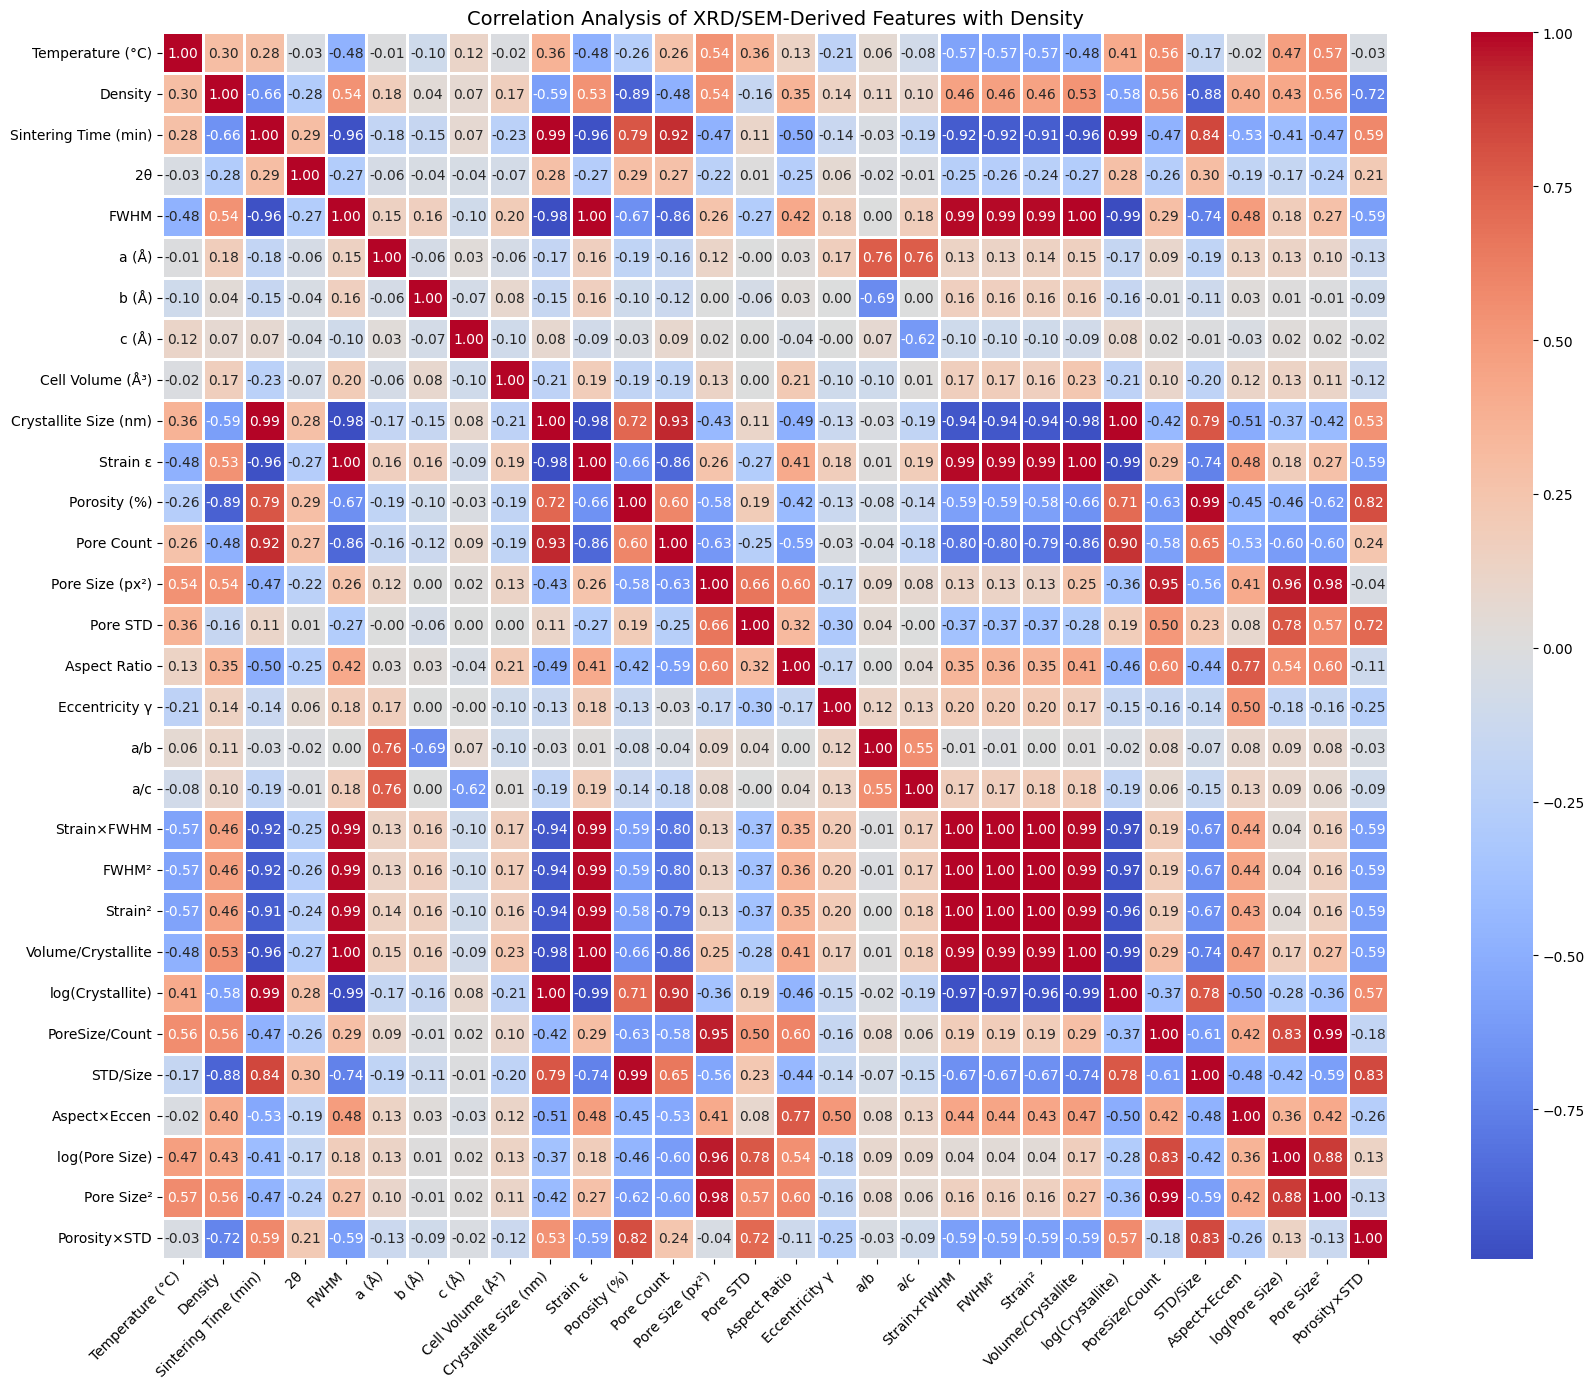

In [ ]:
# ================================================================
# STEP 8: CORRELATION ANALYSIS (Heatmap of Features vs Density)
# ================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# Load the final dataset
# =========================
df_all = pd.read_csv("dataset_density_augmented_clean.csv")

# =========================
# Select only numeric columns
# =========================
df_numeric = df_all.select_dtypes(include=['float64', 'int64'])

# =========================
# Compute correlation matrix
# =========================
corr_matrix = df_numeric.corr()

# =========================
# Plot Heatmap with improved text spacing
# =========================
plt.figure(figsize=(18, 14))  # larger figure to avoid overlap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    square=True,
    linewidths=0.8,          # border lines between cells
    linecolor='white',
    annot_kws={"size": 10}   # font size for annotations
)
plt.title("Correlation Analysis of XRD/SEM-Derived Features with Density", fontsize=14)
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels
plt.yticks(rotation=0)               # keep y-axis labels horizontal
plt.tight_layout()
plt.show()


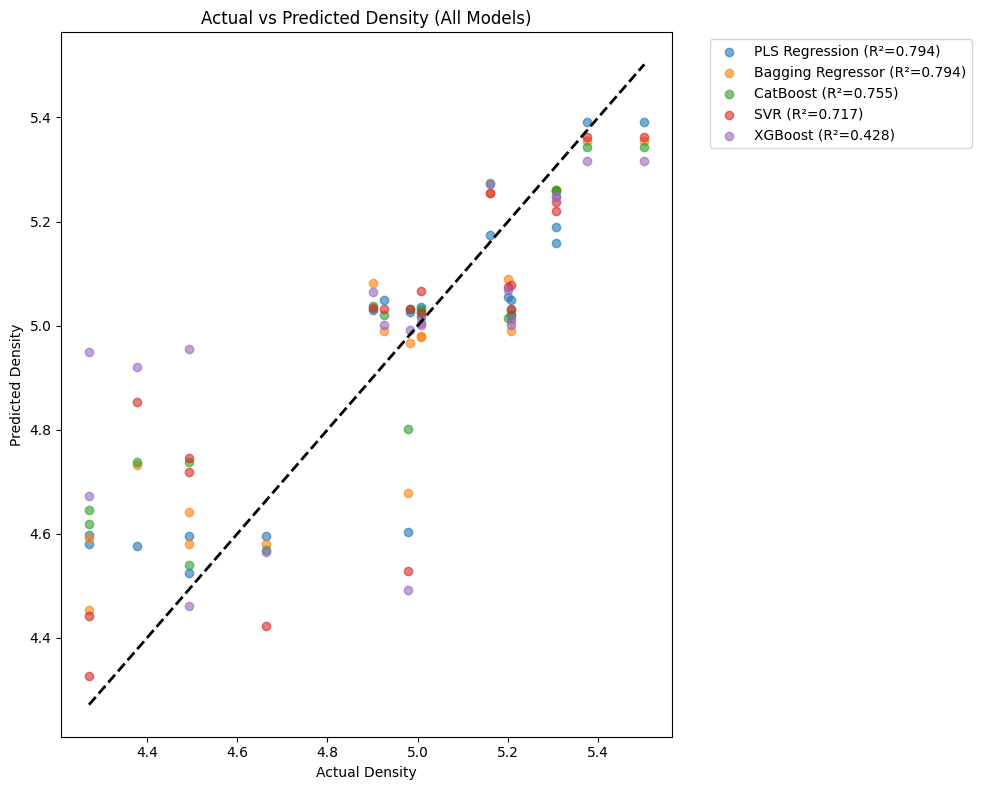

In [ ]:
import matplotlib.pyplot as plt

# =========================
# STEP 8: Scatter Plot Actual vs Predicted (All Models)
# =========================
plt.figure(figsize=(10, 8))

for i, row in df_results.iterrows():
    model_name = row['Model']
    best_params = row['Best_Params']

    # Get base model from dictionary
    base_model = models_grids[model_name]['model']

    # Set parameters if available, else use default
    if best_params and best_params != '–':
        # Convert string parameters to dictionary
        if isinstance(best_params, str):
            params_dict = {}
            for param in best_params.split(','):
                key, val = param.strip().split('=')
                try:
                    val = float(val)  # convert to float if possible
                except:
                    pass  # leave as string if conversion fails
                params_dict[key] = val
            model = base_model.set_params(**params_dict)
        else:
            model = base_model.set_params(**best_params)
    else:
        model = base_model

    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Scatter plot
    plt.scatter(y_test, y_pred, alpha=0.6, label=f"{model_name} (R²={row['R2']:.3f})")

# Plot ideal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel("Actual Density")
plt.ylabel("Predicted Density")
plt.title("Actual vs Predicted Density (All Models)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


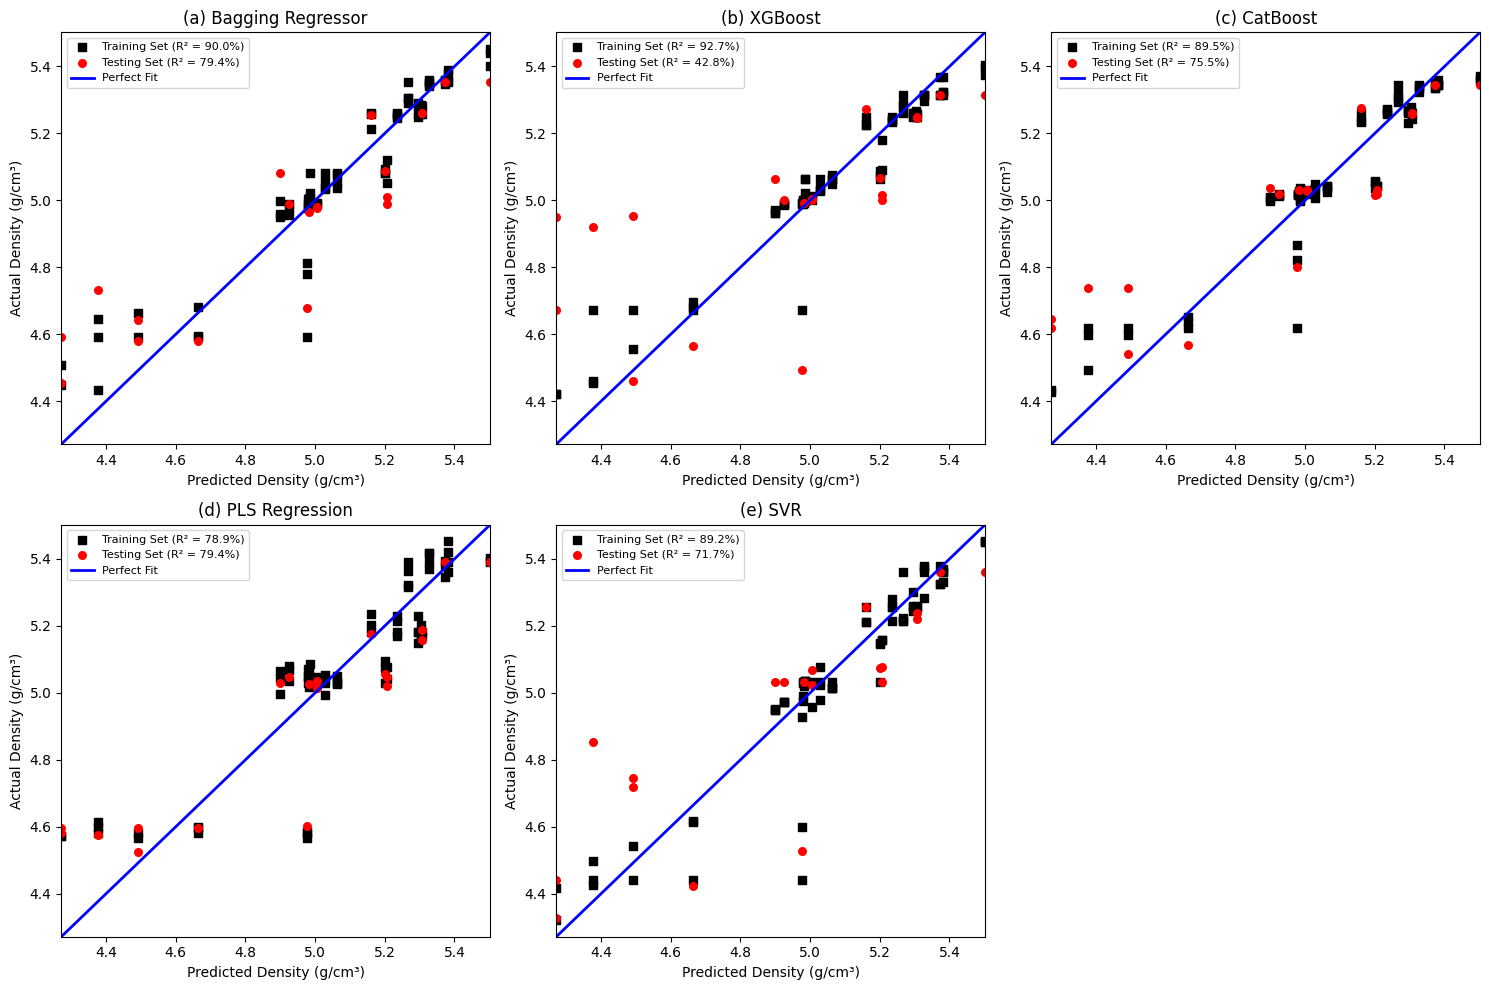

In [ ]:
# =======================================================
# FIG. 3: Comparison of model performance (Train vs Test)
# =======================================================
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(results.items()):
    # Train
    y_train_pred = model.predict(X_train_scaled)
    r2_train = r2_score(y_train, y_train_pred)

    # Test
    y_test_pred = model.predict(X_test_scaled)
    r2_test = r2_score(y_test, y_test_pred)

    # Scatter plot
    ax = axes[idx]
    ax.scatter(y_train, y_train_pred, c='black', marker='s', s=30, label=f"Training Set (R² = {r2_train:.1%})")
    ax.scatter(y_test, y_test_pred, c='red', marker='o', s=30, label=f"Testing Set (R² = {r2_test:.1%})")

    # Perfect fit line
    lims = [min(y), max(y)]
    ax.plot(lims, lims, 'b-', lw=2, label="Perfect Fit")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("Predicted Density (g/cm³)")
    ax.set_ylabel("Actual Density (g/cm³)")
    ax.set_title(f"({chr(97+idx)}) {name}")

    ax.legend(fontsize=8, loc="upper left")

# Remove empty subplot if models < 6
if len(results) < len(axes):
    for j in range(len(results), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


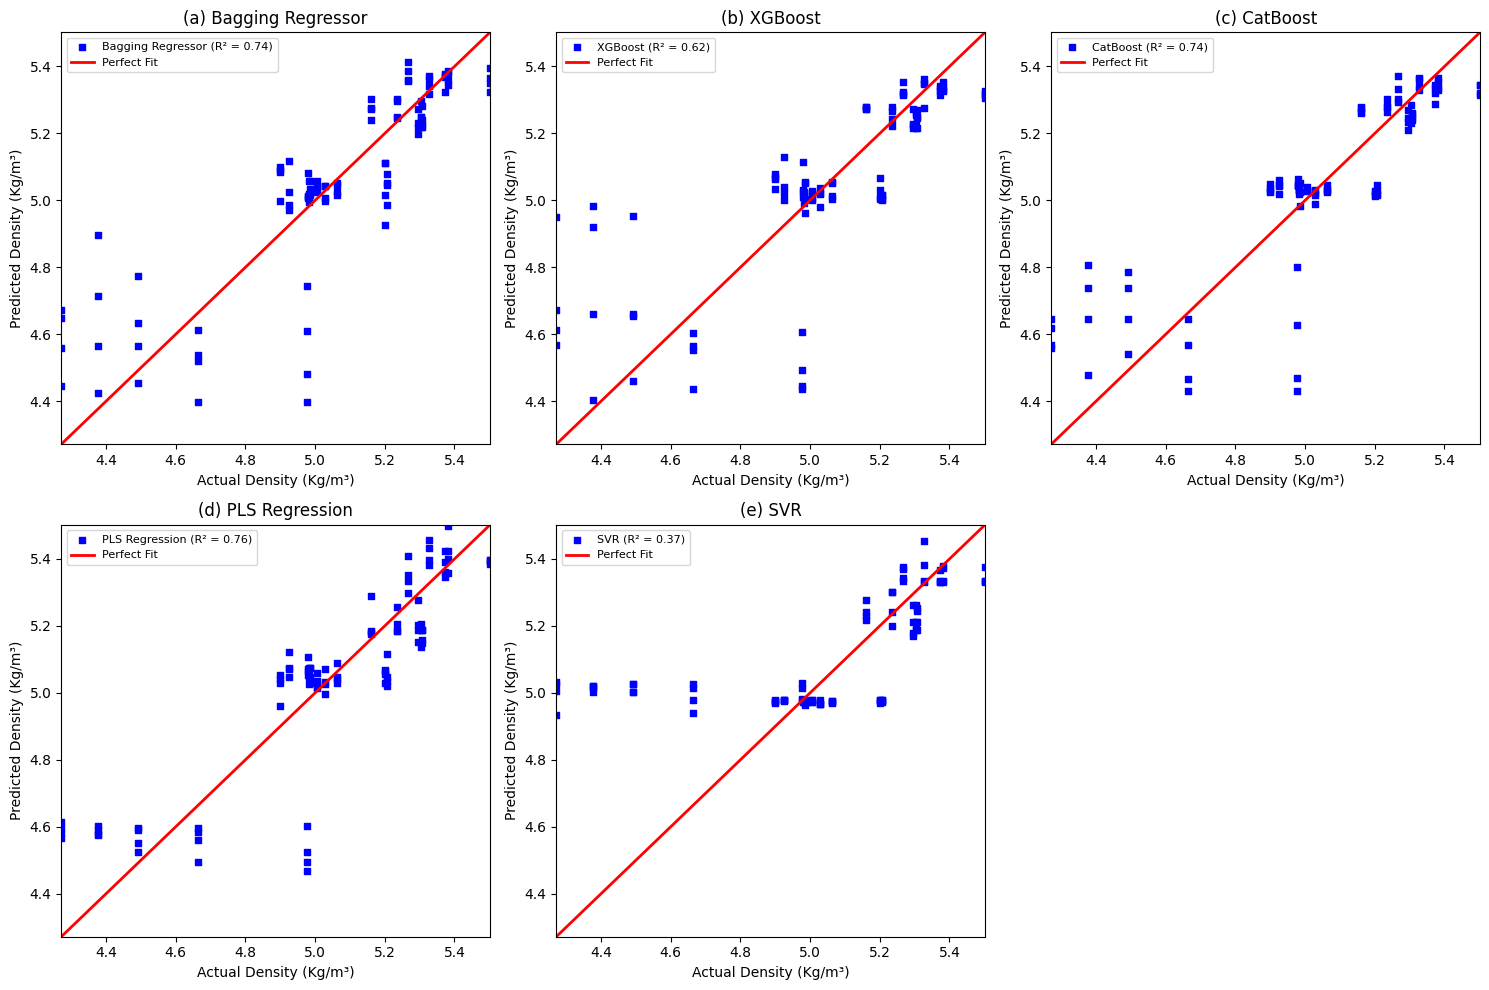

In [ ]:
# =======================================================
# FIG. 4: Performance Evaluation (Validation Dataset)
# =======================================================
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Set random seed
seed = 42
np.random.seed(seed)

# Cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=seed)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(results.items()):
    # Cross-validation predictions
    y_val_pred = cross_val_predict(model, X, y, cv=cv_strategy)
    r2_val = r2_score(y, y_val_pred)

    # Scatter plot
    ax = axes[idx]
    ax.scatter(y, y_val_pred, c='blue', marker='s', s=20,
               label=f"{name} (R² = {r2_val:.2f})")

    # Perfect fit line
    lims = [min(y), max(y)]
    ax.plot(lims, lims, 'r-', lw=2, label="Perfect Fit")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("Actual Density (Kg/m³)")
    ax.set_ylabel("Predicted Density (Kg/m³)")
    ax.set_title(f"({chr(97+idx)}) {name}")

    ax.legend(fontsize=8, loc="upper left")

# Remove empty subplot if models < 6
if len(results) < len(axes):
    for j in range(len(results), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



=== SHAP Analysis for PLS Regression ===


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/tmp/ipython-input-1200217675.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)


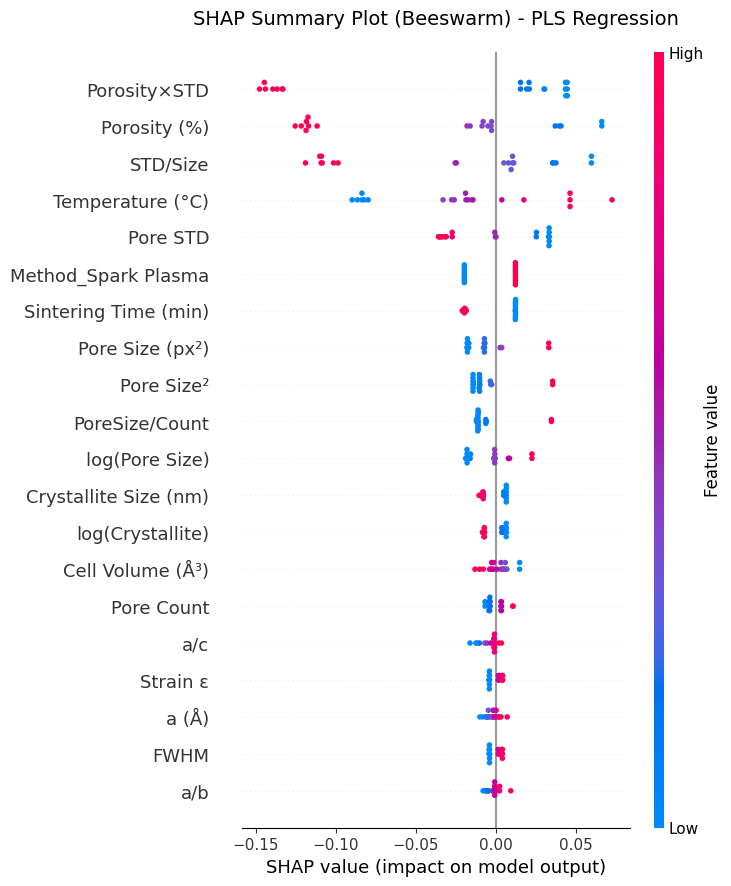

/tmp/ipython-input-1200217675.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)


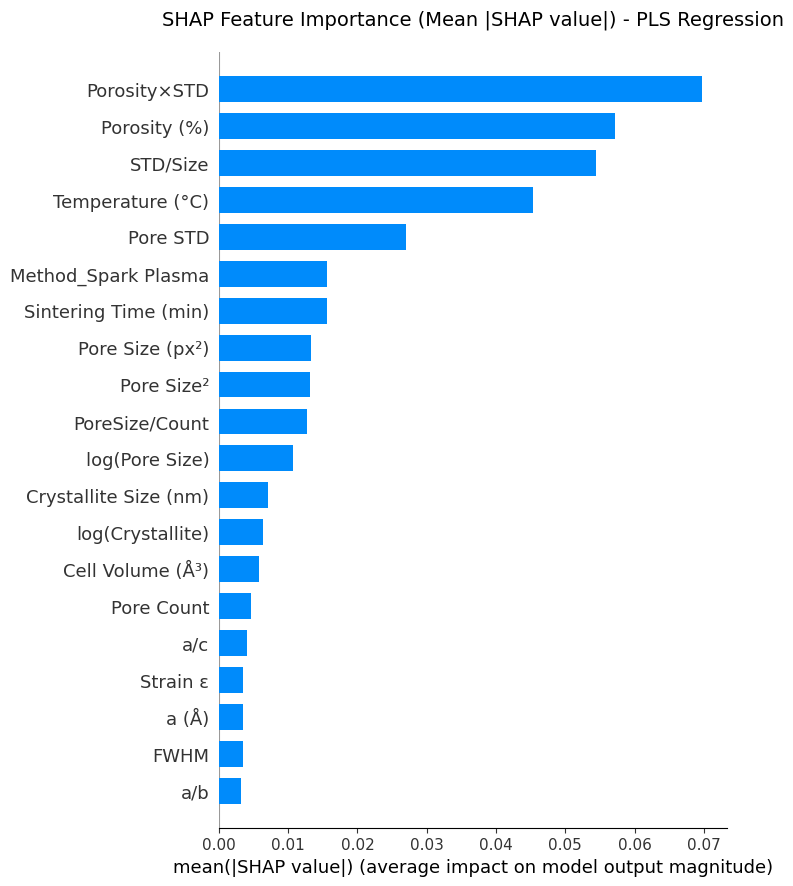

<Figure size 800x600 with 0 Axes>

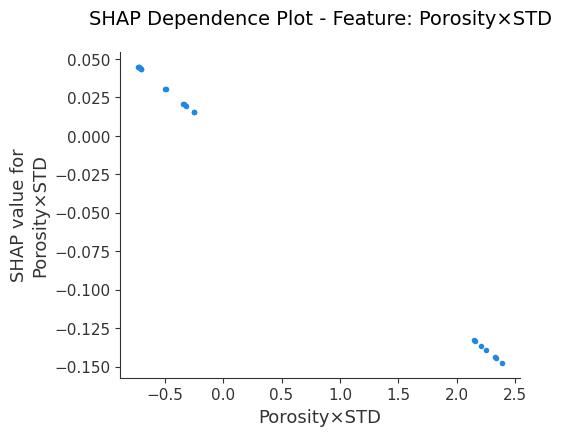

In [ ]:
# =========================
# STEP: SHAP Analysis (PLS Regression as Best Model)
# =========================
import shap
import matplotlib.pyplot as plt

# Ambil row model PLS Regression dari df_results
row = df_results[df_results['Model'] == 'PLS Regression'].iloc[0]
best_params = row['Best_Params']
base_model = models_grids['PLS Regression']['model']

# Set parameters jika ada
if best_params and best_params != '–':
    if isinstance(best_params, str):
        params_dict = {}
        for param in best_params.split(','):
            key, val = param.strip().split('=')
            try:
                val = float(val)
            except:
                pass
            params_dict[key] = val
        model = base_model.set_params(**params_dict)
    else:
        model = base_model.set_params(**best_params)
else:
    model = base_model

# Fit ulang model dengan train data
model.fit(X_train_scaled, y_train)

# =========================
# SHAP Analysis untuk PLS Regression
# =========================
print("\n=== SHAP Analysis for PLS Regression ===")

explainer = shap.LinearExplainer(model, X_train_scaled, feature_perturbation="interventional")
shap_values = explainer(X_test_scaled)

# ========== Summary Plot (Beeswarm) ==========
plt.figure(figsize=(10, 6))  # lebih lebar
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot (Beeswarm) - PLS Regression", fontsize=14, pad=20)
plt.tight_layout(pad=3.0)
plt.show()

# ========== Feature Importance (Bar Plot) ==========
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean |SHAP value|) - PLS Regression", fontsize=14, pad=20)
plt.tight_layout(pad=3.0)
plt.show()

# ========== Dependence Plot untuk fitur terpenting ==========
top_feature = X.columns[np.abs(shap_values.values).mean(0).argmax()]
plt.figure(figsize=(8, 6))
shap.dependence_plot(top_feature, shap_values.values, X_test_scaled, feature_names=X.columns,
                     interaction_index=None, show=False)
plt.title(f"SHAP Dependence Plot - Feature: {top_feature}", fontsize=14, pad=20)
plt.tight_layout(pad=3.0)
plt.show()



=== SHAP Analysis for Bagging Regressor (KernelExplainer) ===


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-3587153759.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns, show=False)


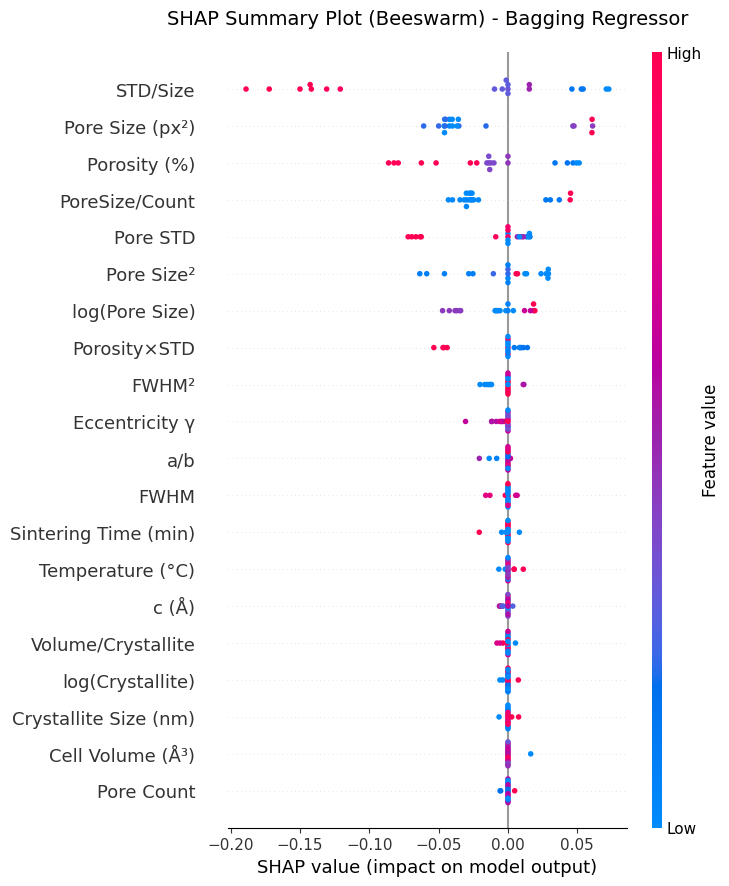

/tmp/ipython-input-3587153759.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns, plot_type="bar", show=False)


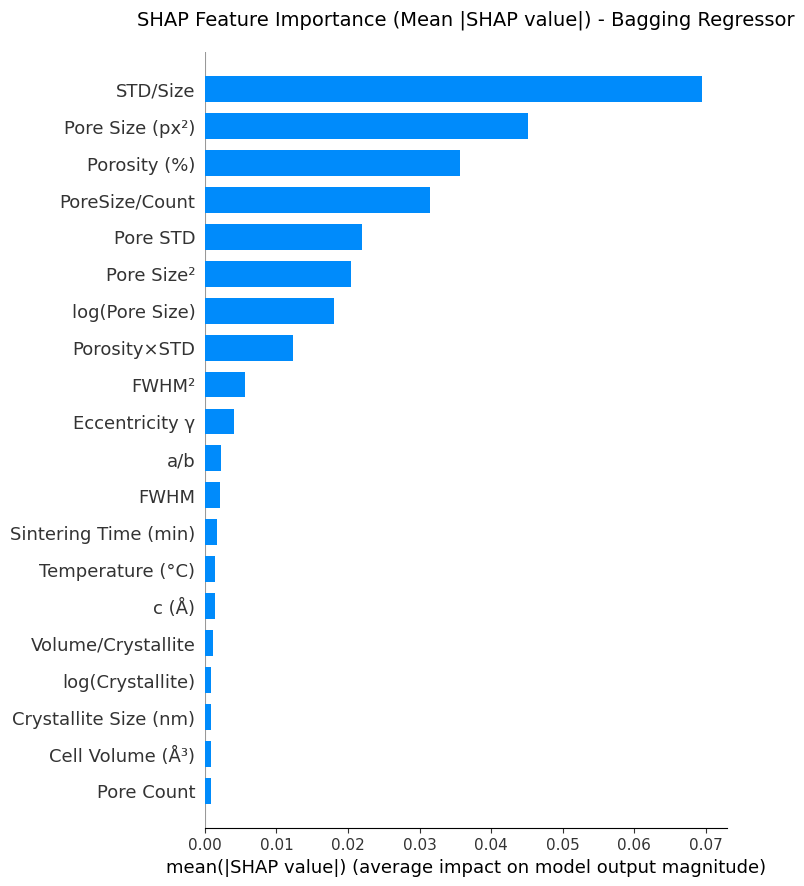

<Figure size 800x600 with 0 Axes>

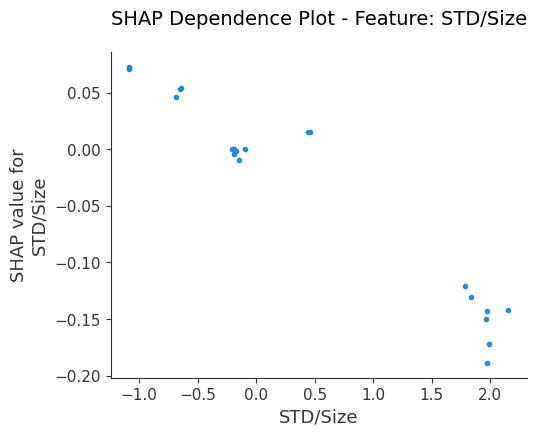

In [ ]:
# =========================
# STEP: SHAP Analysis (Bagging Regressor with KernelExplainer)
# =========================
import shap
import matplotlib.pyplot as plt

print("\n=== SHAP Analysis for Bagging Regressor (KernelExplainer) ===")

# Ambil model Bagging yang sudah di-train
bagging_model = results["Bagging Regressor"]

# Background sample untuk mempercepat KernelExplainer
background = shap.sample(pd.DataFrame(X_train_scaled, columns=X.columns), 50, random_state=SEED)

explainer = shap.KernelExplainer(bagging_model.predict, background)

# Hitung shap values (pakai subset test biar cepat)
shap_values = explainer.shap_values(X_test_scaled[:50], nsamples=200)

# ========== Summary Plot (Beeswarm) ==========
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot (Beeswarm) - Bagging Regressor", fontsize=14, pad=20)
plt.tight_layout(pad=3.0)
plt.show()

# ========== Feature Importance (Bar Plot) ==========
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean |SHAP value|) - Bagging Regressor", fontsize=14, pad=20)
plt.tight_layout(pad=3.0)
plt.show()

# ========== Dependence Plot untuk fitur terpenting ==========
shap_values_arr = np.array(shap_values)
top_feature = X.columns[np.abs(shap_values_arr).mean(0).argmax()]

plt.figure(figsize=(8, 6))
shap.dependence_plot(top_feature, shap_values_arr, X_test_scaled[:50], feature_names=X.columns,
                     interaction_index=None, show=False)
plt.title(f"SHAP Dependence Plot - Feature: {top_feature}", fontsize=14, pad=20)
plt.tight_layout(pad=3.0)
plt.show()
